In [93]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [94]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [95]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [96]:
type(data)

pandas.core.frame.DataFrame

In [97]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-23,112.500000,113.633331,110.566666,113.150002,89.260010,27304806
2019-04-24,113.699997,116.000000,113.233330,115.349998,90.995514,10335498
2019-04-25,115.333336,116.333336,113.699997,114.366669,90.219795,15397809
2019-04-26,114.300003,118.433334,113.500000,117.800003,92.928230,12723930
2019-04-30,117.083336,118.949997,116.183334,118.650002,93.598770,13803423


In [98]:
len(data)

1236

In [99]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-16,203.0,210.100006,201.100006,205.850006,205.850006,31636637
2024-04-18,208.0,213.649994,202.250000,203.550003,203.550003,30645258
2024-04-19,203.0,204.000000,197.250000,201.949997,201.949997,22533995
2024-04-22,204.5,204.500000,195.949997,198.750000,198.750000,36002648
2024-04-23,201.0,202.550003,198.800003,199.500000,199.500000,8313565


In [100]:
opn = data[['Open']]

<Axes: xlabel='Date'>

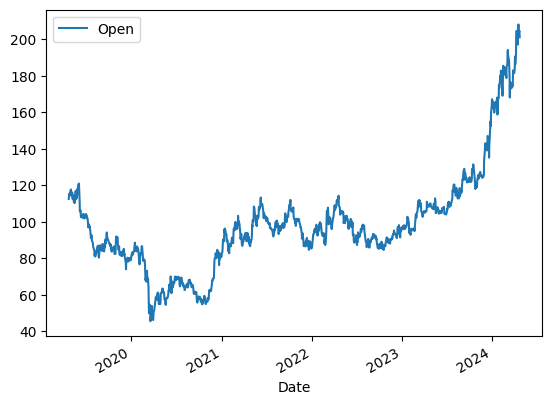

In [101]:
opn.plot()

In [102]:
import matplotlib.pyplot as plt

In [103]:
ds = opn.values

In [104]:
ds

array([[112.5       ],
       [113.69999695],
       [115.33333588],
       ...,
       [203.        ],
       [204.5       ],
       [201.        ]])

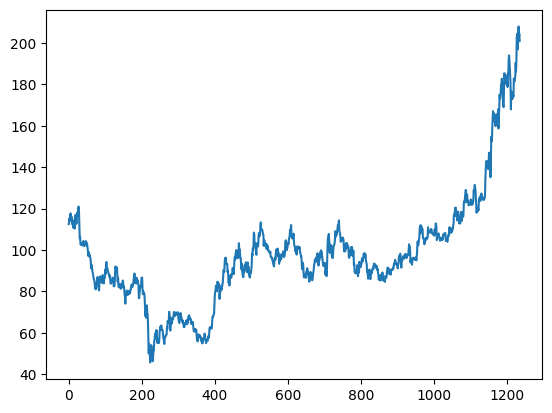

In [105]:
plt.plot(ds)

In [106]:
import numpy as np

In [107]:
from sklearn.preprocessing import MinMaxScaler

In [108]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [109]:
len(ds_scaled), len(ds)

(1236, 1236)

In [110]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [111]:
train_size,test_size

(865, 371)

In [112]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [113]:
len(ds_train),len(ds_test)

(865, 371)

In [114]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [115]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [116]:
X_train.shape,y_train.shape

((764, 100), (764,))

In [117]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [118]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [119]:
import keras
# from keras.models import Sequential
from keras.layers import Dense, LSTM

In [120]:
#Creating LSTM model using keras
model = keras.Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0309 - val_loss: 0.0616
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0051 - val_loss: 0.0135
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0025 - val_loss: 0.0210
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0019 - val_loss: 0.0114
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/ste

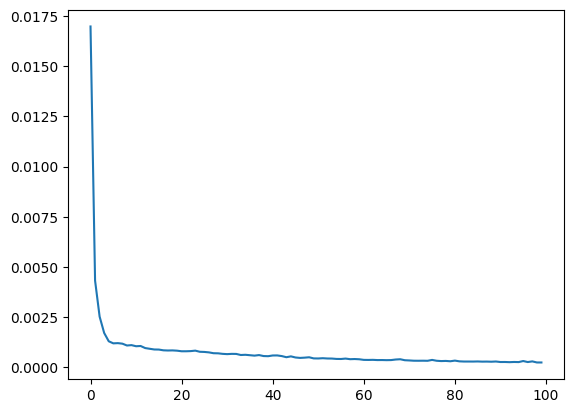

In [122]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [123]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [124]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

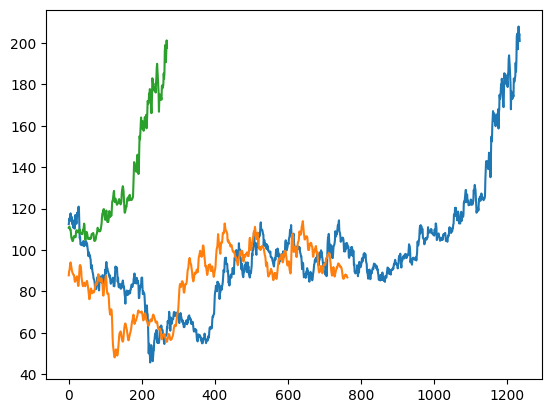

In [125]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [126]:
type(train_predict)

numpy.ndarray

In [127]:
test = np.vstack((train_predict,test_predict))

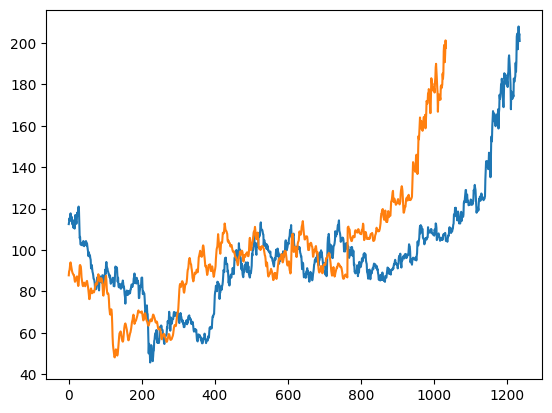

In [128]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [129]:
len(ds_test)

371

In [130]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [131]:
fut_inp = fut_inp.reshape(1,-1)

In [132]:
tmp_inp = list(fut_inp)

In [133]:
fut_inp.shape

(1, 101)

In [134]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [135]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.9250204563140869], [0.8982868790626526], [0.8753204345703125], [0.8586747050285339], [0.8474012613296509], [0.8399873971939087], [0.8349080681800842], [0.8307236433029175], [0.8262701034545898], [0.8207926750183105], [0.8139712810516357], [0.805856466293335], [0.796753466129303], [0.7870962619781494], [0.7773337364196777], [0.7678468823432922], [0.7589029669761658], [0.7506405115127563], [0.7430822849273682], [0.7361613512039185], [0.7297564148902893], [0.7237250208854675], [0.7179316282272339], [0.7122670412063599], [0.7066584229469299], [0.7010709643363953], [0.6955019235610962], [0.6899729371070862], [0.6845185160636902], [0.6791771054267883]]


In [136]:
len(ds_scaled)

1236

In [137]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [138]:
ds_new = ds_scaled.tolist()

In [139]:
len(ds_new)

1236

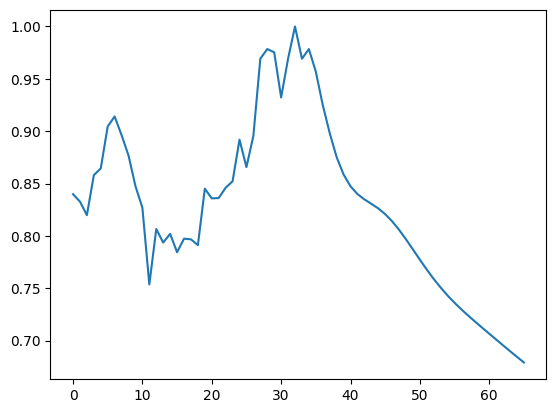

In [140]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

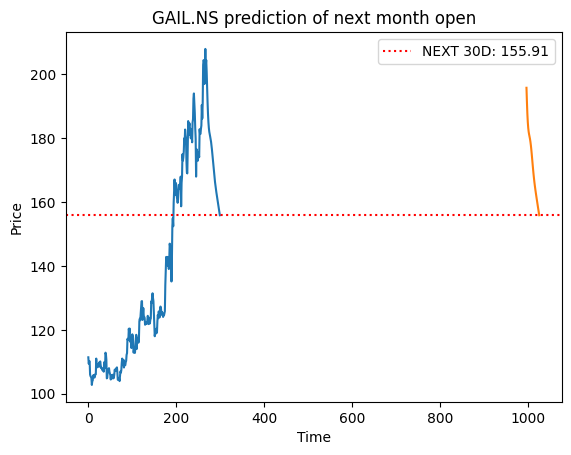

In [141]:
# Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).flatten()  # Flatten the array for plotting

# Calculate the index for plotting the predicted values
start_index = len(ds_scaled) - len(ds_test) + time_stamp + 1  # Starting index for test data
end_index = start_index + len(lst_output)  # Ending index for predicted values

# Plotting final results with predicted value after 30 Days
plt.plot(final_graph[start_index:])  # Plot actual values
plt.plot(np.arange(end_index, end_index + len(lst_output)), normalizer.inverse_transform(lst_output))  # Plot predicted values
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[-1], color='red', linestyle=':', label='NEXT 30D: {0}'.format(round(float(final_graph[-1]), 2)))
plt.legend()
plt.show()

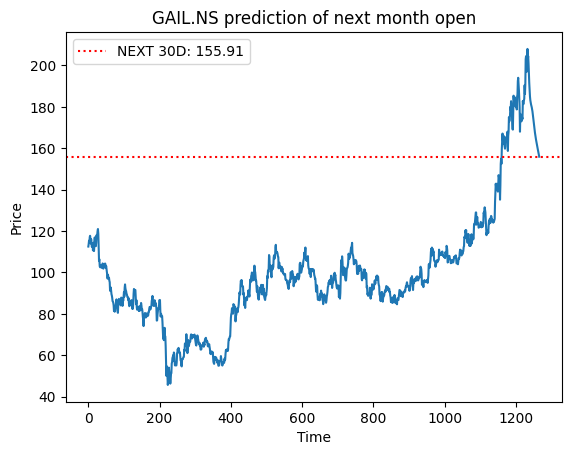

In [143]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[-1], color='red', linestyle=':', label='NEXT 30D: {0}'.format(round(final_graph[-1], 2)))
plt.legend()

